In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.chunk import ne_chunk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

In [2]:
df = pd.read_csv('reddit_pushshift_remove_bots_LargeV2.csv').head(1454) # labelled the 1st 1454 rows

In [3]:
df

,movie_name,genre,original_language,popularity,release_date,vote_average,vote_count,revenue,runtime,author,score,link_id,body,utc_datetime_str,"subjectivity \n{0: neutral,1\n: subjective}","polarity \n{0: negative, \n1: positive}",to remove useless comment \n(0: useful \n1: useless)
0,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,Whale31777,1.0,t3_10z5t71,Im just happy to see you Avatar 2.,11/2/2023 06:01,1.0,1.0,0.0
1,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,njdevils901,1.0,t3_10za4qa,holy shit someone on /r/movies understands why...,11/2/2023 04:17,1.0,1.0,0.0
2,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,Icy-Exchange6457,1.0,t3_10z2ctw,Avatar 2. Absolutely loved the first one and I...,11/2/2023 03:05,1.0,0.0,0.0
3,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,FortitudeWisdom,1.0,t3_10z61yi,"This movie did surprised me. A good film, but ...",11/2/2023 00:27,1.0,1.0,0.0
4,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,Easy-Highlight-5950,1.0,t3_10ywzb1,Jack Champion should replace Ezra Miller as th...,10/2/2023 20:46,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,zwolff94,1.0,t3_10b2j11,Of the post-2000 Spielbergs (that Ive seen whi...,13/1/2023 23:24,1.0,1.0,1.0
1450,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,DevinBelow,1.0,t3_10b2j11,"The Fablemans. Before that, probably West Sid...",13/1/2023 22:57,1.0,1.0,0.0
1451,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,MrsMaiselsBrisket,1.0,t3_10b2j11,"I loved, loved, loved the West Side Story rema...",13/1/2023 22:53,1.0,1.0,0.0
1452,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,DetectiveAmes,1.0,t3_10b2j11,"West side story is a crazy technical feature, ...",13/1/2023 22:42,1.0,1.0,0.0


In [4]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   movie_name                                          1454 non-null   object 
 1   genre                                               1454 non-null   object 
 2   original_language                                   1454 non-null   object 
 3   popularity                                          1454 non-null   float64
 4   release_date                                        1454 non-null   object 
 5   vote_average                                        1454 non-null   float64
 6   vote_count                                          1454 non-null   float64
 7   revenue                                             1454 non-null   float64
 8   runtime                                             1454 non-null   float64
 9

(1454, 17)

In [5]:
grps = ['subjectivity \n{0: neutral,1\n: subjective}', 'polarity \n{0: negative, \n1: positive}', 'to remove useless comment \n(0: useful \n1: useless)']

for col_name in grps:
    counts = df[col_name].value_counts()
    print(f'\nFeature:{col_name}')
    print(counts)


Feature:subjectivity 
{0: neutral,1
: subjective}
1.0    1258
0.0     186
Name: subjectivity \n{0: neutral,1\n: subjective}, dtype: int64

Feature:polarity 
{0: negative, 
1: positive}
1.0    728
0.0    716
Name: polarity \n{0: negative, \n1: positive}, dtype: int64

Feature:to remove useless comment 
(0: useful 
1: useless)
1.0    819
0.0    634
Name: to remove useless comment \n(0: useful \n1: useless), dtype: int64


In [6]:
new_df = df[df['to remove useless comment \n(0: useful \n1: useless)'] == 0].reset_index(drop=True)
new_df

,movie_name,genre,original_language,popularity,release_date,vote_average,vote_count,revenue,runtime,author,score,link_id,body,utc_datetime_str,"subjectivity \n{0: neutral,1\n: subjective}","polarity \n{0: negative, \n1: positive}",to remove useless comment \n(0: useful \n1: useless)
0,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,Whale31777,1.0,t3_10z5t71,Im just happy to see you Avatar 2.,11/2/2023 06:01,1.0,1.0,0.0
1,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,njdevils901,1.0,t3_10za4qa,holy shit someone on /r/movies understands why...,11/2/2023 04:17,1.0,1.0,0.0
2,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,Icy-Exchange6457,1.0,t3_10z2ctw,Avatar 2. Absolutely loved the first one and I...,11/2/2023 03:05,1.0,0.0,0.0
3,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,FortitudeWisdom,1.0,t3_10z61yi,"This movie did surprised me. A good film, but ...",11/2/2023 00:27,1.0,1.0,0.0
4,Avatar 2,"Action, Adventure, Science Fiction, Fantasy",en,58.466,2022-12-14,0.0,0.0,0.0,0.0,yousyveshughs,1.0,t3_10yfvyj,The Batman kinda sucked though. It was boring ...,10/2/2023 20:05,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,AnyNamesLeftAnymore,1.0,t3_10b2j11,I thought Lincoln and Bridge of Spies were bot...,14/1/2023 00:20,1.0,1.0,0.0
630,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,TheRidiculousOtaku,1.0,t3_10b2j11,IDK man West Side story was pretty fantastic.\...,13/1/2023 23:47,1.0,1.0,0.0
631,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,DevinBelow,1.0,t3_10b2j11,"The Fablemans. Before that, probably West Sid...",13/1/2023 22:57,1.0,1.0,0.0
632,West Side Story,"Drama, Romance, Crime",en,13.236,2021-12-08,0.0,0.0,0.0,156.0,MrsMaiselsBrisket,1.0,t3_10b2j11,"I loved, loved, loved the West Side Story rema...",13/1/2023 22:53,1.0,1.0,0.0


In [7]:
grps = ['subjectivity \n{0: neutral,1\n: subjective}', 'polarity \n{0: negative, \n1: positive}', 'to remove useless comment \n(0: useful \n1: useless)']

for col_name in grps:
    counts = new_df[col_name].value_counts()
    print(f'\nFeature:{col_name}')
    print(counts)


Feature:subjectivity 
{0: neutral,1
: subjective}
1.0    627
0.0      7
Name: subjectivity \n{0: neutral,1\n: subjective}, dtype: int64

Feature:polarity 
{0: negative, 
1: positive}
1.0    324
0.0    310
Name: polarity \n{0: negative, \n1: positive}, dtype: int64

Feature:to remove useless comment 
(0: useful 
1: useless)
0.0    634
Name: to remove useless comment \n(0: useful \n1: useless), dtype: int64


In [8]:
new_df[['movie_name', 'body']]

,movie_name,body
0,Avatar 2,Im just happy to see you Avatar 2.
1,Avatar 2,holy shit someone on /r/movies understands why...
2,Avatar 2,Avatar 2. Absolutely loved the first one and I...
3,Avatar 2,"This movie did surprised me. A good film, but ..."
4,Avatar 2,The Batman kinda sucked though. It was boring ...
...,...,...
629,West Side Story,I thought Lincoln and Bridge of Spies were bot...
630,West Side Story,IDK man West Side story was pretty fantastic.\...
631,West Side Story,"The Fablemans. Before that, probably West Sid..."
632,West Side Story,"I loved, loved, loved the West Side Story rema..."


In [9]:
movies = [mov for mov in new_df['movie_name'].unique()]
print(movies)
print(f'Total: {len(movies)}')

['Avatar 2', 'Black Panther: Wakanda Forever', 'Black Adam', 'Love and Thunder', 'The Rise of Gru', 'Jurassic World: Dominion', 'Doctor Strange in the Multiverse of Madness', 'Top Gun: Maverick', 'Fantastic Beasts: The Secrets of Dumbledore', 'The Dark Realm', 'Sonic the Hedgehog 2', 'Turning Red', 'The Batman', 'Jackass Forever', 'The Black Phone', 'Morbius', 'Hotel Transylvania: Transformania', 'The Lost Girls', 'Jeepers Creepers: Reborn', "The King's Man", 'Swan Song', 'The Matrix Resurrections', 'No Way Home', "Don't Look Up", 'West Side Story']
Total: 25


In [10]:
new_df['body'] = new_df['body'].str.lower()
new_df['body']

0                     im just happy to see you avatar 2.
1      holy shit someone on /r/movies understands why...
2      avatar 2. absolutely loved the first one and i...
3      this movie did surprised me. a good film, but ...
4      the batman kinda sucked though. it was boring ...
                             ...                        
629    i thought lincoln and bridge of spies were bot...
630    idk man west side story was pretty fantastic.\...
631    the fablemans.  before that, probably west sid...
632    i loved, loved, loved the west side story rema...
633    west side story is a crazy technical feature, ...
Name: body, Length: 634, dtype: object

# VADER

In [38]:
sia = SentimentIntensityAnalyzer()
res = {}
for idx, row in enumerate(new_df['body']):
    sent_tokens = nltk.sent_tokenize(row) 
    word_tokens = nltk.word_tokenize(row)
    tag = nltk.pos_tag(word_tokens)
    pol = sia.polarity_scores(row)
    res[idx] = pol

#     print(f'Row{idx}: {sent_tokens}\n')
#     print(f'Row{idx}: {word_tokens}\n')
#     print(f'Row{idx}: {tag}\n')
#     print(f'Row{idx}: {row}\n{pol}\n')

In [12]:
res

{0: {'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'compound': 0.5719},
 1: {'neg': 0.18, 'neu': 0.598, 'pos': 0.222, 'compound': 0.2148},
 2: {'neg': 0.29, 'neu': 0.574, 'pos': 0.136, 'compound': -0.941},
 3: {'neg': 0.041, 'neu': 0.65, 'pos': 0.309, 'compound': 0.9629},
 4: {'neg': 0.357, 'neu': 0.505, 'pos': 0.138, 'compound': -0.8036},
 5: {'neg': 0.092, 'neu': 0.576, 'pos': 0.331, 'compound': 0.8244},
 6: {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404},
 7: {'neg': 0.307, 'neu': 0.599, 'pos': 0.094, 'compound': -0.6908},
 8: {'neg': 0.129, 'neu': 0.707, 'pos': 0.164, 'compound': 0.34},
 9: {'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'compound': 0.7506},
 10: {'neg': 0.0, 'neu': 0.8, 'pos': 0.2, 'compound': 0.8402},
 11: {'neg': 0.0, 'neu': 0.712, 'pos': 0.288, 'compound': 0.9366},
 12: {'neg': 0.103, 'neu': 0.76, 'pos': 0.137, 'compound': 0.169},
 13: {'neg': 0.093, 'neu': 0.657, 'pos': 0.25, 'compound': 0.7346},
 14: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 15:

In [13]:
pd.DataFrame(res).T

,neg,neu,pos,compound
0,0.000,0.654,0.346,0.5719
1,0.180,0.598,0.222,0.2148
2,0.290,0.574,0.136,-0.9410
3,0.041,0.650,0.309,0.9629
4,0.357,0.505,0.138,-0.8036
...,...,...,...,...
629,0.049,0.760,0.192,0.6507
630,0.200,0.597,0.203,0.2732
631,0.000,1.000,0.000,0.0000
632,0.000,0.724,0.276,0.8422


In [14]:
vaders = pd.DataFrame(res).T
merged = pd.concat([new_df, vaders], axis=1)
merged[['subjectivity \n{0: neutral,1\n: subjective}', 'polarity \n{0: negative, \n1: positive}', 'neg', 'neu', 'pos', 'compound']]

,"subjectivity \n{0: neutral,1\n: subjective}","polarity \n{0: negative, \n1: positive}",neg,neu,pos,compound
0,1.0,1.0,0.000,0.654,0.346,0.5719
1,1.0,1.0,0.180,0.598,0.222,0.2148
2,1.0,0.0,0.290,0.574,0.136,-0.9410
3,1.0,1.0,0.041,0.650,0.309,0.9629
4,1.0,1.0,0.357,0.505,0.138,-0.8036
...,...,...,...,...,...,...
629,1.0,1.0,0.049,0.760,0.192,0.6507
630,1.0,1.0,0.200,0.597,0.203,0.2732
631,1.0,1.0,0.000,1.000,0.000,0.0000
632,1.0,1.0,0.000,0.724,0.276,0.8422


Text(0.5, 1.0, 'Positive')

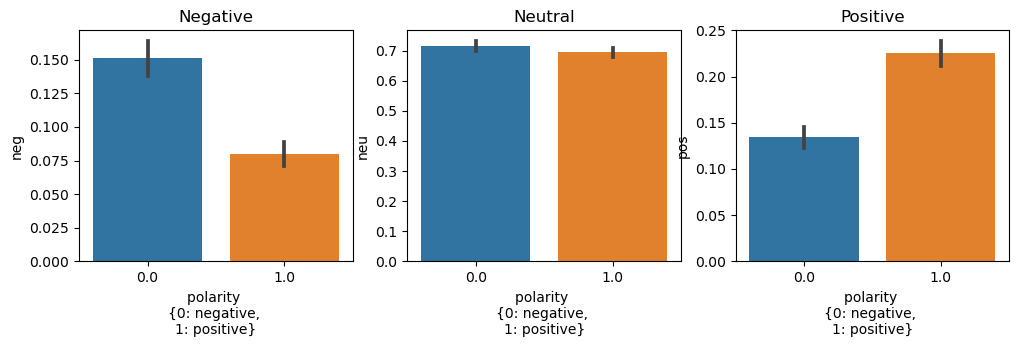

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=merged, x='polarity \n{0: negative, \n1: positive}', y='neg', ax=axs[0])
sns.barplot(data=merged, x='polarity \n{0: negative, \n1: positive}', y='neu', ax=axs[1])
sns.barplot(data=merged, x='polarity \n{0: negative, \n1: positive}', y='pos', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')

# RoBERTA

In [18]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\TQ\anaconda3\envs\venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\TQ\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [43]:
def roberta_polarity(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'rob_neg': scores[0],
        'rob_neu': scores[1],
        'rob_pos': scores[2],
    }
    return scores_dict

In [44]:
rob_res = {}
for idx, row in enumerate(new_df['body']): 
    roberta = roberta_polarity(row)
    rob_res[idx] = roberta

In [45]:
rob_res

{0: {'rob_neg': 0.002033472, 'rob_neu': 0.023830332, 'rob_pos': 0.9741362},
 1: {'rob_neg': 0.003806826, 'rob_neu': 0.04669953, 'rob_pos': 0.9494936},
 2: {'rob_neg': 0.23606916, 'rob_neu': 0.23338196, 'rob_pos': 0.53054893},
 3: {'rob_neg': 0.06182799, 'rob_neu': 0.24241228, 'rob_pos': 0.6957597},
 4: {'rob_neg': 0.94418377, 'rob_neu': 0.047074605, 'rob_pos': 0.008741587},
 5: {'rob_neg': 0.63610053, 'rob_neu': 0.28416452, 'rob_pos': 0.07973497},
 6: {'rob_neg': 0.030922348, 'rob_neu': 0.14938736, 'rob_pos': 0.8196903},
 7: {'rob_neg': 0.817551, 'rob_neu': 0.16781226, 'rob_pos': 0.014636698},
 8: {'rob_neg': 0.038347293, 'rob_neu': 0.34218553, 'rob_pos': 0.6194672},
 9: {'rob_neg': 0.030644512, 'rob_neu': 0.21904162, 'rob_pos': 0.7503139},
 10: {'rob_neg': 0.013679454, 'rob_neu': 0.07411078, 'rob_pos': 0.91220975},
 11: {'rob_neg': 0.0025340104, 'rob_neu': 0.015658159, 'rob_pos': 0.98180777},
 12: {'rob_neg': 0.7712347, 'rob_neu': 0.20196454, 'rob_pos': 0.026800776},
 13: {'rob_neg': 

In [46]:
pd.DataFrame(rob_res).T

,rob_neg,rob_neu,rob_pos
0,0.002033,0.023830,0.974136
1,0.003807,0.046700,0.949494
2,0.236069,0.233382,0.530549
3,0.061828,0.242412,0.695760
4,0.944184,0.047075,0.008742
...,...,...,...
629,0.011789,0.113116,0.875095
630,0.152101,0.329217,0.518681
631,0.170697,0.544449,0.284854
632,0.002202,0.010562,0.987236


In [47]:
rob = pd.DataFrame(rob_res).T
merged = pd.concat([merged, rob], axis=1)
merged[['subjectivity \n{0: neutral,1\n: subjective}', 'polarity \n{0: negative, \n1: positive}', 'neg', 'neu', 'pos', 'compound', 'rob_neg', 'rob_neu', 'rob_pos']]

,"subjectivity \n{0: neutral,1\n: subjective}","polarity \n{0: negative, \n1: positive}",neg,neu,pos,compound,rob_neg,rob_neu,rob_pos
0,1.0,1.0,0.000,0.654,0.346,0.5719,0.002033,0.023830,0.974136
1,1.0,1.0,0.180,0.598,0.222,0.2148,0.003807,0.046700,0.949494
2,1.0,0.0,0.290,0.574,0.136,-0.9410,0.236069,0.233382,0.530549
3,1.0,1.0,0.041,0.650,0.309,0.9629,0.061828,0.242412,0.695760
4,1.0,1.0,0.357,0.505,0.138,-0.8036,0.944184,0.047075,0.008742
...,...,...,...,...,...,...,...,...,...
629,1.0,1.0,0.049,0.760,0.192,0.6507,0.011789,0.113116,0.875095
630,1.0,1.0,0.200,0.597,0.203,0.2732,0.152101,0.329217,0.518681
631,1.0,1.0,0.000,1.000,0.000,0.0000,0.170697,0.544449,0.284854
632,1.0,1.0,0.000,0.724,0.276,0.8422,0.002202,0.010562,0.987236


Text(0.5, 1.0, 'Positive')

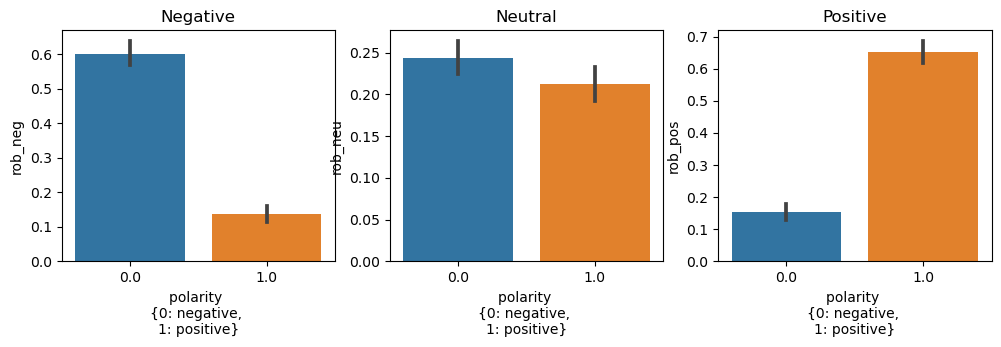

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=merged, x='polarity \n{0: negative, \n1: positive}', y='rob_neg', ax=axs[0])
sns.barplot(data=merged, x='polarity \n{0: negative, \n1: positive}', y='rob_neu', ax=axs[1])
sns.barplot(data=merged, x='polarity \n{0: negative, \n1: positive}', y='rob_pos', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')

<function matplotlib.pyplot.show(close=None, block=None)>

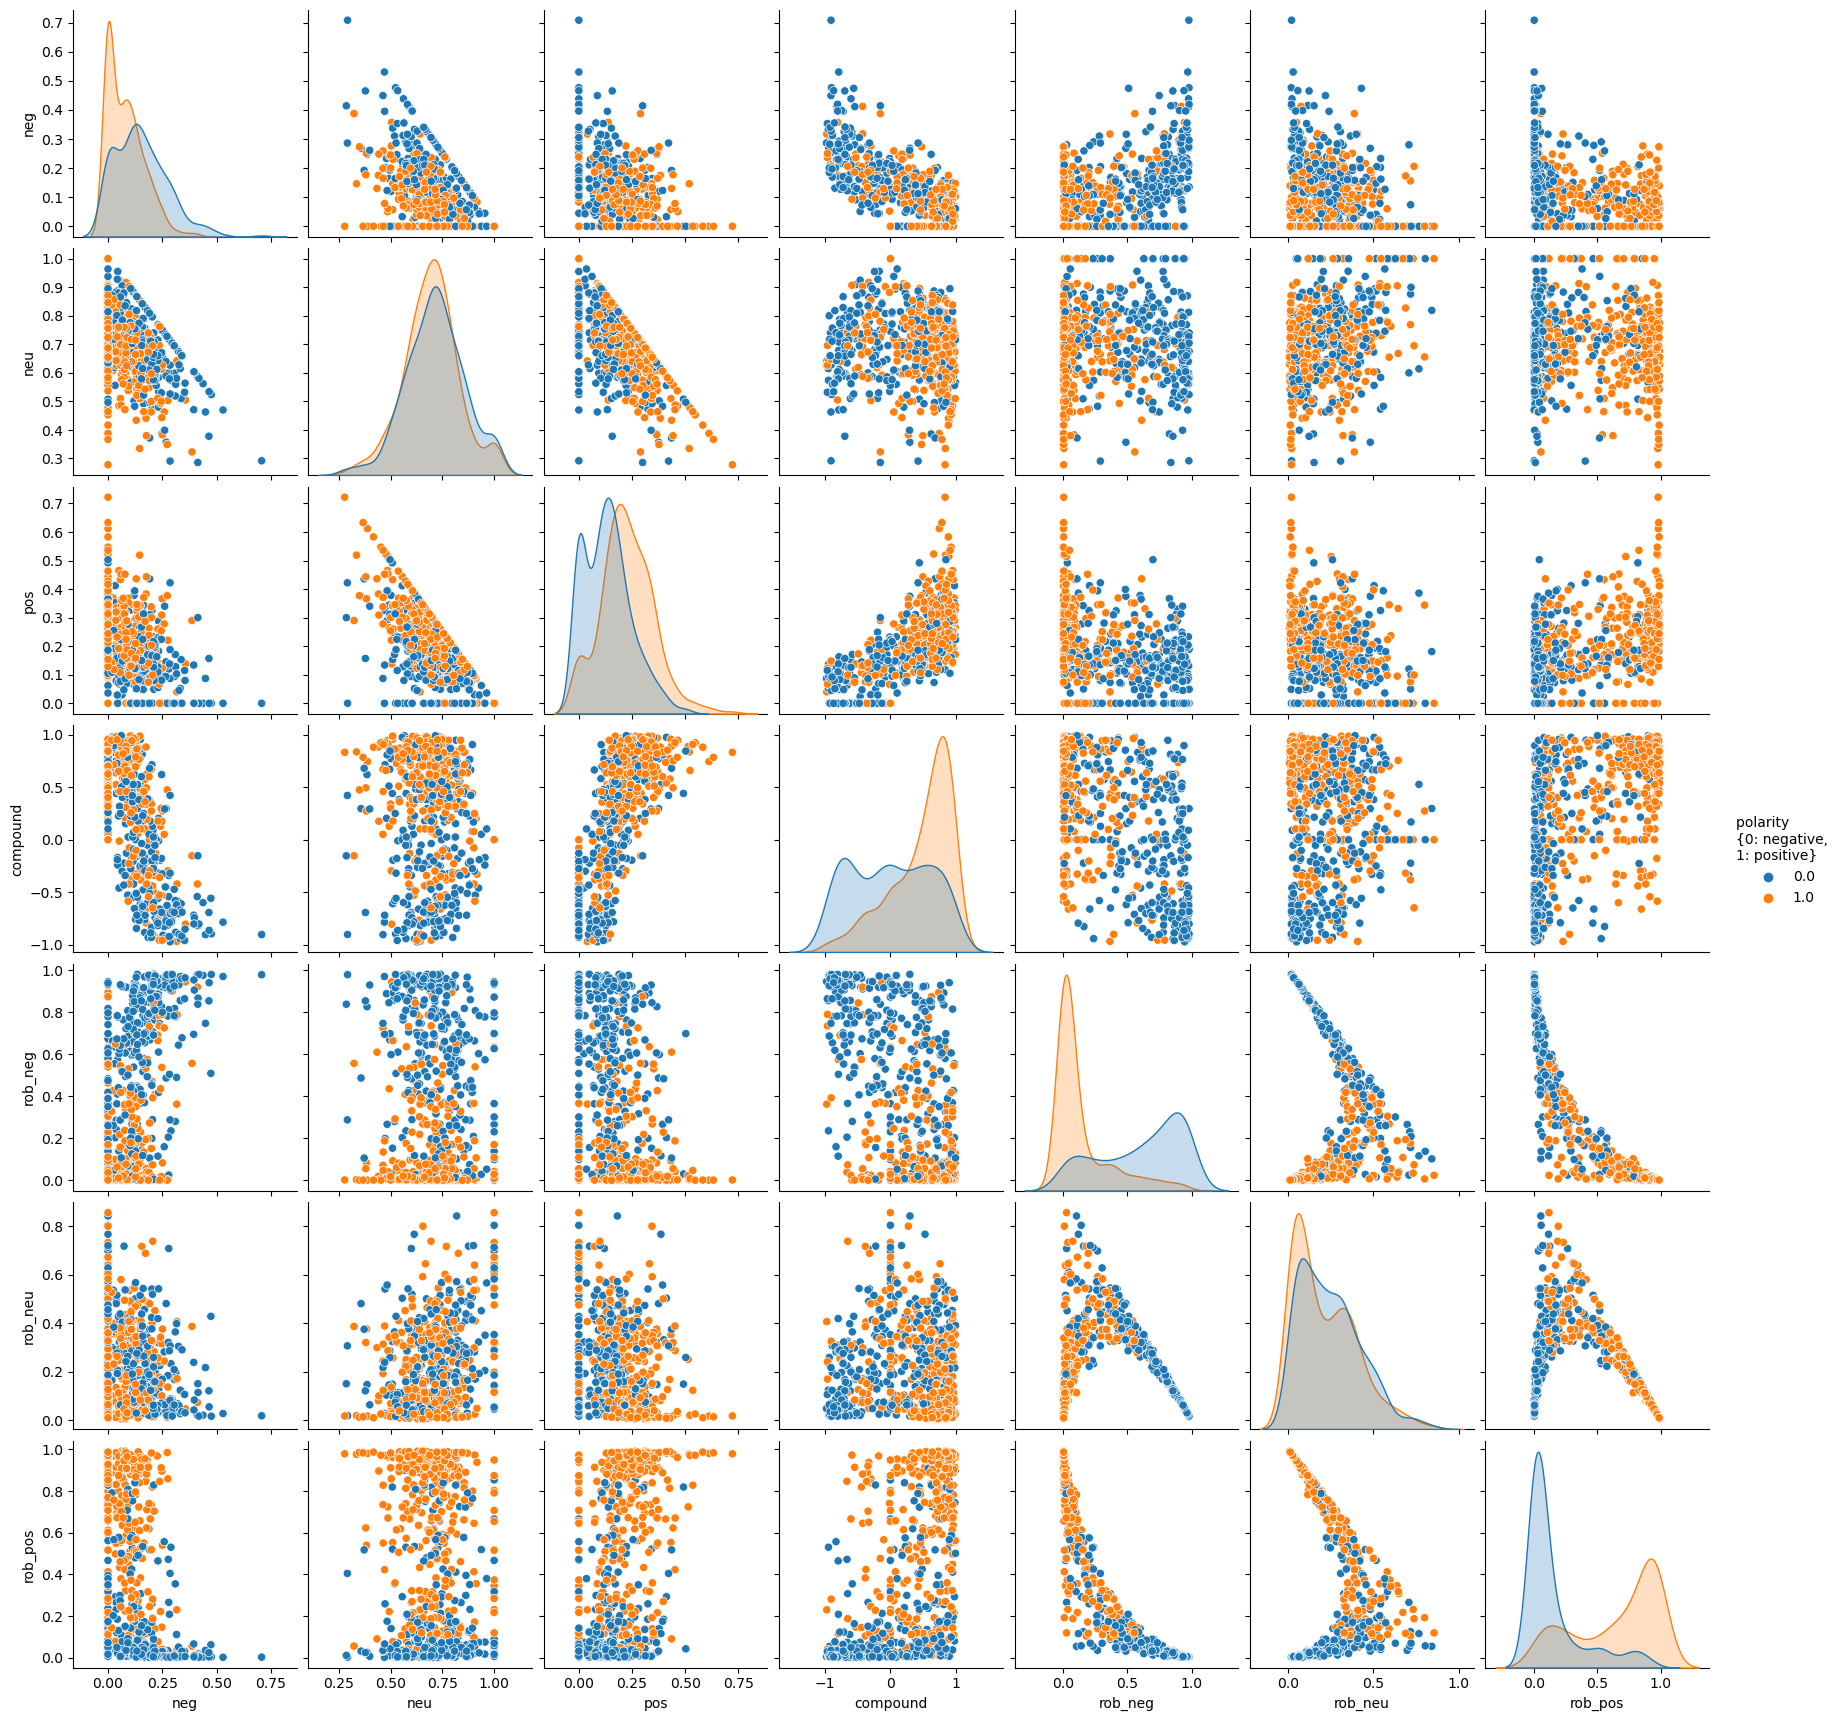

In [57]:
sns.pairplot(data=merged,
             vars=['neg', 'neu','pos', 'compound', 'rob_neg', 'rob_neu', 'rob_pos'],
             hue='polarity \n{0: negative, \n1: positive}'
            )
plt.show

# Using Simple Pipeline

In [59]:
# Change string to name of model to use if needed
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [60]:
sent_pipeline(merged['body'][0])

[{'label': 'POSITIVE', 'score': 0.9998552799224854}]

In [67]:
sent = {}
for idx, row in enumerate(new_df['body']): 
    sent[idx] = sent_pipeline(merged['body'][idx])

In [68]:
sent

{0: [{'label': 'POSITIVE', 'score': 0.9998552799224854}],
 1: [{'label': 'POSITIVE', 'score': 0.9961841702461243}],
 2: [{'label': 'NEGATIVE', 'score': 0.9959642887115479}],
 3: [{'label': 'POSITIVE', 'score': 0.9957576394081116}],
 4: [{'label': 'NEGATIVE', 'score': 0.9990608096122742}],
 5: [{'label': 'POSITIVE', 'score': 0.9957261085510254}],
 6: [{'label': 'POSITIVE', 'score': 0.9905546307563782}],
 7: [{'label': 'NEGATIVE', 'score': 0.999745786190033}],
 8: [{'label': 'POSITIVE', 'score': 0.9661932587623596}],
 9: [{'label': 'POSITIVE', 'score': 0.9960766434669495}],
 10: [{'label': 'POSITIVE', 'score': 0.9997807145118713}],
 11: [{'label': 'POSITIVE', 'score': 0.9996592998504639}],
 12: [{'label': 'NEGATIVE', 'score': 0.9966546297073364}],
 13: [{'label': 'POSITIVE', 'score': 0.9431169033050537}],
 14: [{'label': 'NEGATIVE', 'score': 0.9996546506881714}],
 15: [{'label': 'NEGATIVE', 'score': 0.9789578914642334}],
 16: [{'label': 'NEGATIVE', 'score': 0.9995110034942627}],
 17: [{'